In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

import numpy as np
from msapy import plottings as pl
import matplotlib.pyplot as plt
import scipy.io

import seaborn as sns
import utils as ut
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from scipy.stats import pearsonr

from neurolib.models.hopf import HopfModel
import neurolib.utils.functions as func
from matplotlib import font_manager
from visual_config import *

for font in font_manager.findSystemFonts("figures/Atkinson_Typeface/"):
    font_manager.fontManager.addfont(font)

set_visual_style()

In [4]:
SEED = 2023

In [5]:
consensus_mat = scipy.io.loadmat(
    "Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
consensus_mat["LauConsensus"]["Readme"]

array(['1 - weighted adj mat', '2 - fiber length mat', '3 - fc mat',
       '4 - coordinates', '5{1} - roi name', '5{2} - short name',
       '5{3} - rsn name', '5{4} - hemisphere'], dtype=object)

In [6]:
connectivity = ut.spectral_normalization(
    1, consensus_mat["LauConsensus"]["Matrices"][2][0]
)
labels = consensus_mat["LauConsensus"]["Matrices"][2][4][:, 0]
human_fc = consensus_mat["LauConsensus"]["Matrices"][2][2]
fiber_lengths = consensus_mat["LauConsensus"]["Matrices"][2][1]

np.fill_diagonal(human_fc, 0)

In [7]:
macaque_sc = ut.spectral_normalization(
    1, np.loadtxt("macaqueSC")
)
macaque_fc = np.loadtxt("macaqueFC")
mouse_sc = ut.spectral_normalization(
    1, np.loadtxt("mouseSC")
)
mouse_fc = np.loadtxt("mouseFC")

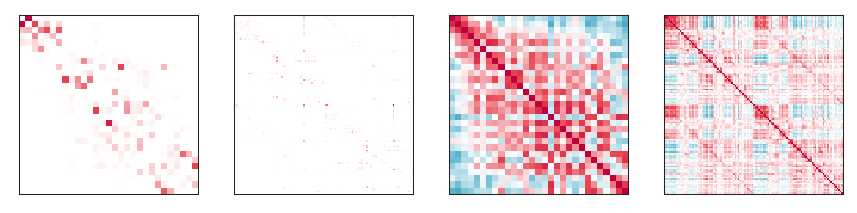

In [8]:
fig, axes = plt.subplot_mosaic([["A", "B", "C", "D"]], figsize=HALF_PAGE, dpi=150)
sns.heatmap(
    macaque_sc,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["A"],
    cbar=False,
)

sns.heatmap(
    mouse_sc,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["B"],
    cbar=False,
)

sns.heatmap(
    macaque_fc,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=diverge_from_white,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["C"],
    cbar=False,
    center=0,
)

sns.heatmap(
    mouse_fc,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=diverge_from_white,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["D"],
    cbar=False,
    center=0,
)
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

In [9]:
n_nodes = connectivity.shape[0]
rng = np.random.default_rng(seed=SEED)
delta = 0.01
tau = 0.02

G = 0.74  # this is the optimal value based on the search below
duration = 1000
noise_strength = 0.05

noise = np.zeros((n_nodes, int(duration / delta) + 1))
for i in range(int(duration / delta) + 1):
    noise[:, i] = rng.normal(0, noise_strength, (n_nodes,))

## Macaque

In [10]:
parameter_space = list(
    ParameterGrid(
        {
            "G": np.linspace(0.01, 1.0, 20).round(
                2,
            )
        }
    )
)

n_nodes = macaque_sc.shape[0]
rng = np.random.default_rng(seed=SEED)
delta = 0.01
tau = 0.02

duration = 1000
noise_strength = 0.05

noise = np.zeros((n_nodes, int(duration / delta) + 1))
for i in range(int(duration / delta) + 1):
    noise[:, i] = rng.normal(0, noise_strength, (n_nodes,))

In [11]:
for parameters in tqdm(
    parameter_space, total=len(parameter_space), desc="Optimizing hyperparams: "
):
    dynamics = ut.simulate_dynamical_system_parallel(
        adjacency_matrix=macaque_sc,
        coupling=parameters["G"],
        dt=delta,
        timeconstant=tau,
        input_matrix=noise,
        duration=duration,
    )

    fc = np.corrcoef(dynamics)
    np.fill_diagonal(fc, 0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({"correlation": 0})
    else:
        r = np.corrcoef(
            macaque_fc[np.triu_indices_from(macaque_fc, k=1)],
            fc[np.triu_indices_from(fc, k=1)],
        )[0, 1]
        parameters.update({"correlation": r})

Optimizing hyperparams:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing hyperparams: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


In [12]:
optimum_params = max(parameter_space, key=lambda x: x["correlation"])
dynamics = ut.simulate_dynamical_system_parallel(
    adjacency_matrix=macaque_sc,
    coupling=optimum_params["G"],
    dt=delta,
    timeconstant=tau,
    input_matrix=noise,
    duration=duration,
)
fc = np.corrcoef(dynamics)
np.fill_diagonal(fc, 0)
optimum_params

{'G': 0.64, 'correlation': 0.45770147837097724}

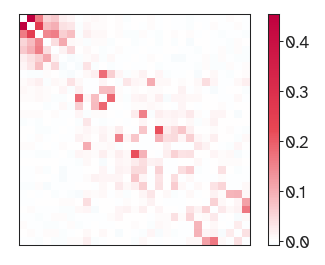

In [13]:
plt.figure(figsize=(3, 2), dpi=150)
sns.heatmap(
    fc,
    square=True,
    center=0,
    cmap=diverge_from_white,
    linewidths=0.0,
    yticklabels=False,
    xticklabels=False,
)
sns.despine(top=False, right=False, left=False, bottom=False)

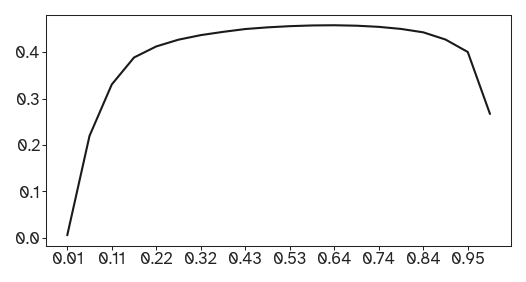

In [14]:
fit_results = []
for index, correlation in enumerate(parameter_space):
    fit_results.append(parameter_space[index]["correlation"])

plt.figure(figsize=(4, 2), dpi=150)
plt.plot(fit_results, color="k")
plt.xticks(
    np.arange(0, 20, 2),
    np.linspace(0.01, 1.0, 20).round(
        2,
    )[::2],
);

## Mouse

In [15]:
n_nodes = mouse_sc.shape[0]
rng = np.random.default_rng(seed=SEED)
noise = np.zeros((n_nodes, int(duration / delta) + 1))
for i in range(int(duration / delta) + 1):
    noise[:, i] = rng.normal(0, noise_strength, (n_nodes,))

In [16]:
for parameters in tqdm(
    parameter_space, total=len(parameter_space), desc="Optimizing hyperparams: "
):
    dynamics = ut.simulate_dynamical_system_parallel(
        adjacency_matrix=mouse_sc,
        coupling=parameters["G"],
        dt=delta,
        timeconstant=tau,
        input_matrix=noise,
        duration=duration,
    )

    fc = np.corrcoef(dynamics)
    np.fill_diagonal(fc, 0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({"correlation": 0})
    else:
        r = np.corrcoef(
            mouse_fc[np.triu_indices_from(mouse_fc, k=1)],
            fc[np.triu_indices_from(fc, k=1)],
        )[0, 1]
        parameters.update({"correlation": r})

Optimizing hyperparams: 100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


In [17]:
optimum_params = max(parameter_space, key=lambda x: x["correlation"])
dynamics = ut.simulate_dynamical_system_parallel(
    adjacency_matrix=mouse_sc,
    coupling=optimum_params["G"],
    dt=delta,
    timeconstant=tau,
    input_matrix=noise,
    duration=duration,
)
fc = np.corrcoef(dynamics)
np.fill_diagonal(fc, 0)
optimum_params

{'G': 0.79, 'correlation': 0.2202357538616707}

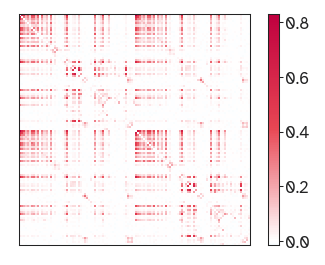

In [18]:
plt.figure(figsize=(3, 2), dpi=150)
sns.heatmap(
    fc,
    square=True,
    center=0,
    cmap=diverge_from_white,
    linewidths=0.0,
    yticklabels=False,
    xticklabels=False,
)
sns.despine(top=False, right=False, left=False, bottom=False)

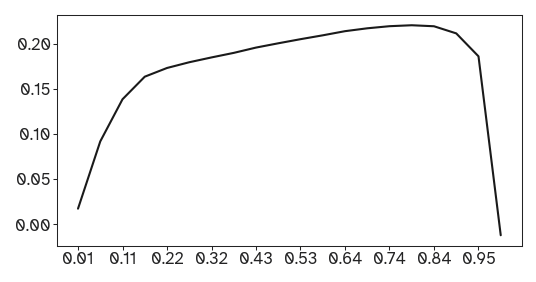

In [19]:
fit_results = []
for index, correlation in enumerate(parameter_space):
    fit_results.append(parameter_space[index]["correlation"])

plt.figure(figsize=(4, 2), dpi=150)
plt.plot(fit_results, color="k")
plt.xticks(
    np.arange(0, 20, 2),
    np.linspace(0.01, 1.0, 20).round(
        2,
    )[::2],
);

## Human

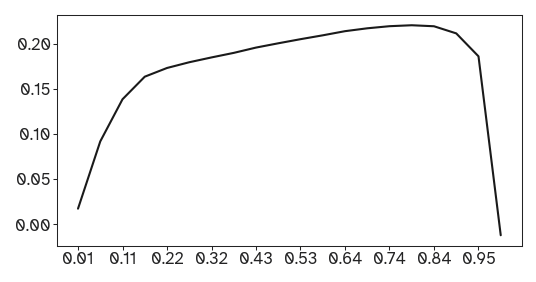

In [20]:
fit_results = []
for index, correlation in enumerate(parameter_space):
    fit_results.append(parameter_space[index]["correlation"])

plt.figure(figsize=(4, 2), dpi=150)
plt.plot(fit_results, color="k")
plt.xticks(
    np.arange(0, 20, 2),
    np.linspace(0.01, 1.0, 20).round(
        2,
    )[::2],
);

In [21]:
model = HopfModel(
    Cmat=connectivity,
    Dmat=fiber_lengths,
)
model.params["sigma_ou"] = noise_strength
model.params["seed"] = SEED
model.params["duration"] = 50 * 1000

In [22]:
rng = np.random.default_rng(seed=SEED)
hopf_parameter_space = list(
    ParameterGrid(
        {
            "K_gl": np.linspace(0.0, 8, 41).round(2),
            "a": np.linspace(-0.25, 0.25, 6).round(2),
        }
    )
)

for parameters in tqdm(
    hopf_parameter_space,
    total=len(hopf_parameter_space),
    desc="Optimizing hyperparams: ",
):
    model.params["K_gl"] = parameters["K_gl"]
    model.params["a"] = parameters["a"]
    model.run(chunkwise=True)

    fc = func.fc(model.x)

    if fc.mean() > 0.9:
        parameters.update({"correlation": 0})
    else:
        r = func.matrix_correlation(human_fc, fc)
        parameters.update({"correlation": r})

hopf_optimum_params = max(hopf_parameter_space, key=lambda x: x["correlation"])
hopf_optimum_params

Optimizing hyperparams:   0%|          | 0/246 [00:00<?, ?it/s]

Optimizing hyperparams: 100%|██████████| 246/246 [3:51:20<00:00, 56.43s/it]  


{'K_gl': 8.0, 'a': 0.15, 'correlation': 0.3452398355629165}

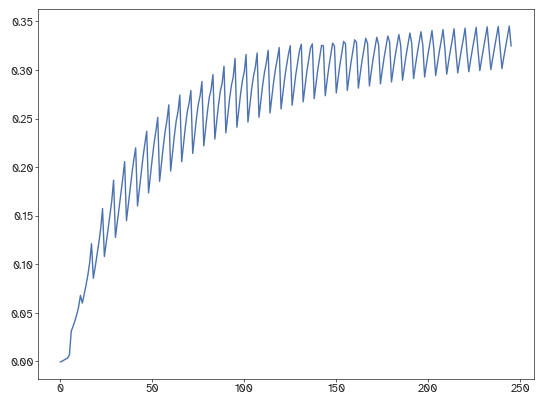

In [23]:
fit_results = []
for index, correlation in enumerate(hopf_parameter_space):
    fit_results.append(hopf_parameter_space[index]["correlation"])
plt.plot(fit_results);

In [24]:
model.params["K_gl"] = hopf_optimum_params["K_gl"]
model.run(chunkwise=True)

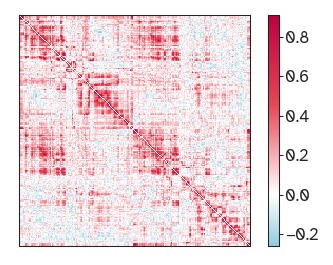

In [25]:
fc = np.corrcoef(model.x)
np.fill_diagonal(fc, 0)

plt.figure(figsize=(3, 2), dpi=150)
sns.heatmap(
    fc,
    square=True,
    center=0,
    cmap=diverge_from_white,
    linewidths=0.0,
    yticklabels=False,
    xticklabels=False,
)
sns.despine(top=False, right=False, left=False, bottom=False)
#plt.savefig(f"figures/Hopf/HOPF_FC.pdf", dpi=600, bbox_inches="tight")

In [26]:
model = HopfModel(
    Cmat=connectivity,
    Dmat=fiber_lengths / 50,
)
model.params["sigma_ou"] = noise_strength
model.params["seed"] = SEED
model.params["duration"] = 50 * 1000
model.params["a"] = 0.15

rng = np.random.default_rng(seed=SEED)
hopf_parameter_space = list(ParameterGrid({"K_gl": np.linspace(0.0, 8, 41).round(2)}))

for parameters in tqdm(
    hopf_parameter_space,
    total=len(hopf_parameter_space),
    desc="Optimizing hyperparams: ",
):
    model.params["K_gl"] = parameters["K_gl"]
    model.run(chunkwise=True)

    fc = func.fc(model.x)

    if fc.mean() > 0.9:
        parameters.update({"correlation": 0})
    else:
        r = func.matrix_correlation(human_fc, fc)
        parameters.update({"correlation": r})

hopf_optimum_params = max(hopf_parameter_space, key=lambda x: x["correlation"])
hopf_optimum_params

Optimizing hyperparams:   0%|          | 0/41 [00:00<?, ?it/s]

Optimizing hyperparams: 100%|██████████| 41/41 [34:56<00:00, 51.13s/it]


{'K_gl': 3.4, 'correlation': 0.33888461694866434}

PearsonRResult(statistic=0.3807673210230636, pvalue=0.0)

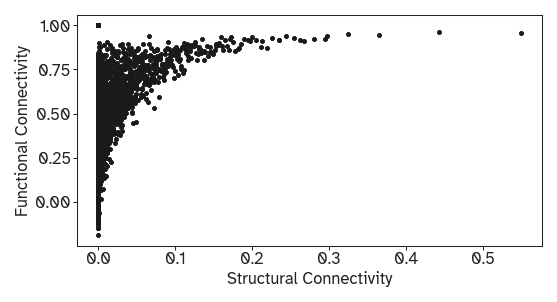

In [27]:
plt.figure(figsize=(4, 2), dpi=150)
sns.scatterplot(x=connectivity.flatten(), y=fc.flatten(), color="k", s=5, linewidth=0)
plt.xlabel("Structural Connectivity")
plt.ylabel("Functional Connectivity")

pearsonr(connectivity.flatten(), fc.flatten())

In [28]:
n_nodes = connectivity.shape[0]
rng = np.random.default_rng(seed=SEED)

noise = np.zeros((n_nodes, int(duration / delta) + 1))
for i in range(int(duration / delta) + 1):
    noise[:, i] = rng.normal(0, noise_strength, (n_nodes,))

simple_human_dynamics = ut.simulate_dynamical_system_parallel(
    adjacency_matrix=connectivity,
    coupling=G,
    dt=delta,
    timeconstant=tau,
    input_matrix=noise,
    duration=duration,
)

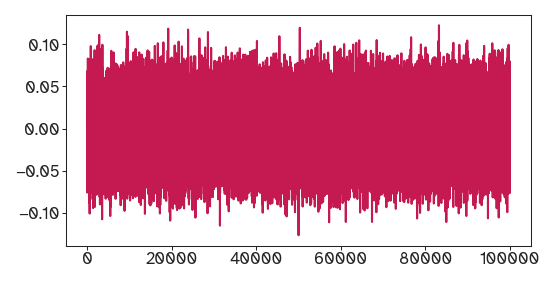

In [29]:
plt.figure(figsize=(4, 2), dpi=150)
plt.plot(simple_human_dynamics[10], alpha=0.9, color=RED)
fc = np.corrcoef(simple_human_dynamics)
np.fill_diagonal(fc, 0)
fc = np.nan_to_num(fc)

0.2341694295016316

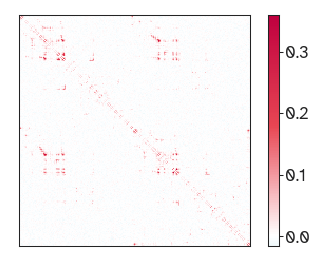

In [30]:
plt.figure(figsize=(3, 2), dpi=150)
sns.heatmap(
    fc,
    square=True,
    center=0,
    cmap=diverge_from_white,
    linewidths=0.0,
    yticklabels=False,
    xticklabels=False,
)
sns.despine(top=False, right=False, left=False, bottom=False)
np.corrcoef(
    human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)]
)[0, 1]

PearsonRResult(statistic=0.8188924074292805, pvalue=0.0)

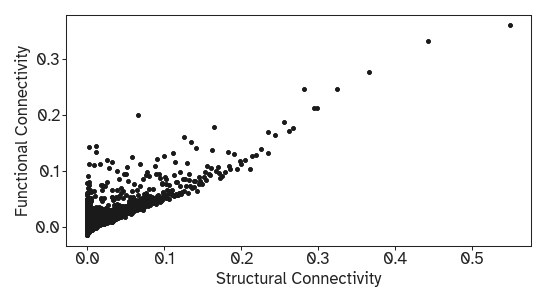

In [31]:
plt.figure(figsize=(4, 2), dpi=150)
from scipy.stats import pearsonr

sns.scatterplot(x=connectivity.flatten(), y=fc.flatten(), color="k", s=5, linewidth=0)
plt.xlabel("Structural Connectivity")
plt.ylabel("Functional Connectivity")

pearsonr(connectivity.flatten(), fc.flatten())

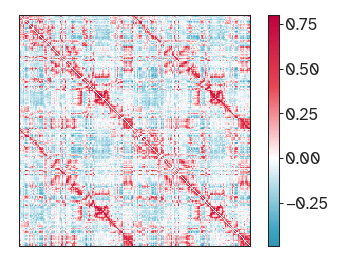

In [32]:
plt.figure(figsize=(3, 2), dpi=150)
sns.heatmap(
    human_fc,
    square=True,
    center=0,
    cmap=diverge_from_white,
    linewidths=0.0,
    yticklabels=False,
    xticklabels=False,
)
sns.despine(top=False, right=False, left=False, bottom=False)
#plt.savefig(f"figures/Human_FC.pdf", dpi=600, bbox_inches="tight")

PearsonRResult(statistic=0.8188924074292805, pvalue=0.0)

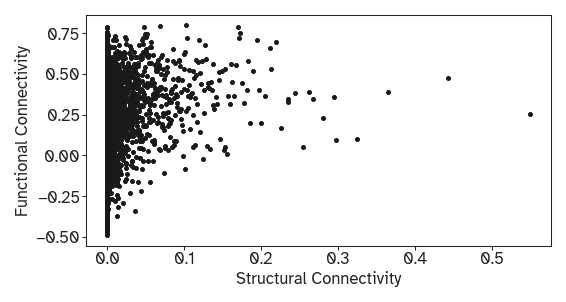

In [33]:
plt.figure(figsize=(4, 2), dpi=150)

sns.scatterplot(
    x=connectivity.flatten(), y=human_fc.flatten(), color="k", s=5, linewidth=0
)
plt.xlabel("Structural Connectivity")
plt.ylabel("Functional Connectivity")

pearsonr(connectivity.flatten(), fc.flatten())

In [34]:
for parameters in tqdm(
    parameter_space, total=len(parameter_space), desc="Optimizing hyperparams: "
):
    dynamics = ut.simulate_dynamical_system_parallel(
        adjacency_matrix=connectivity,
        coupling=parameters["G"],
        dt=delta,
        timeconstant=tau,
        input_matrix=noise,
        duration=duration,
    )

    fc = np.corrcoef(dynamics)
    np.fill_diagonal(fc, 0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({"correlation": 0})
    else:
        r = np.corrcoef(
            human_fc[np.triu_indices_from(human_fc, k=1)],
            fc[np.triu_indices_from(fc, k=1)],
        )[0, 1]
        parameters.update({"correlation": r})

Optimizing hyperparams:   5%|▌         | 1/20 [00:08<02:37,  8.30s/it]

Optimizing hyperparams: 100%|██████████| 20/20 [02:46<00:00,  8.31s/it]


In [35]:
optimum_params = max(parameter_space, key=lambda x: x["correlation"])
dynamics = ut.simulate_dynamical_system_parallel(
    adjacency_matrix=connectivity,
    coupling=optimum_params["G"],
    dt=delta,
    timeconstant=tau,
    input_matrix=noise,
    duration=duration,
)
fc = np.corrcoef(dynamics)
np.fill_diagonal(fc, 0)
optimum_params

{'G': 0.74, 'correlation': 0.2341694295016316}

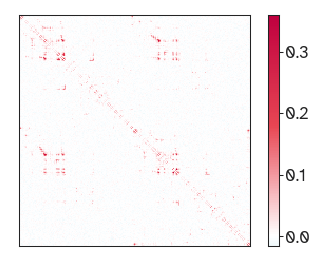

In [36]:
plt.figure(figsize=(3, 2), dpi=150)
sns.heatmap(
    fc,
    square=True,
    center=0,
    cmap=diverge_from_white,
    linewidths=0.0,
    yticklabels=False,
    xticklabels=False,
)
sns.despine(top=False, right=False, left=False, bottom=False)

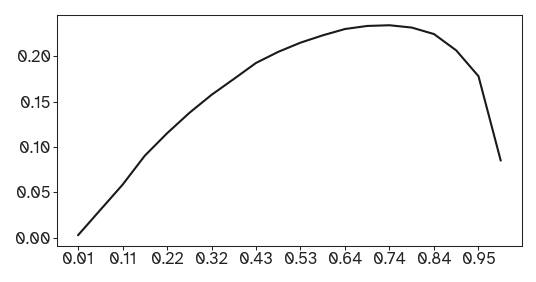

In [37]:
fit_results = []
for index, correlation in enumerate(parameter_space):
    fit_results.append(parameter_space[index]["correlation"])

plt.figure(figsize=(4, 2), dpi=150)
plt.plot(fit_results, color="k")
plt.xticks(
    np.arange(0, 20, 2),
    np.linspace(0.01, 1.0, 20).round(
        2,
    )[::2],
);

In [38]:
dynamics.shape

(219, 100001)